In [60]:
from yako_util import util as q
from yako_util import era5 as era5
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sklearn.metrics as metrics
import sklearn
from metpy.calc import mixing_ratio_from_specific_humidity, density
from metpy.units import units
from metpy.constants import g
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor
from torch.utils.data import DataLoader, TensorDataset
import torch
import random
from xgboost import XGBRegressor
from sklearn.cluster import KMeans

In [61]:
np.random.seed(132)
random.seed(132)

np.set_printoptions(suppress=True, precision=3)
torch.use_deterministic_algorithms(True)

## Load dataset

In [62]:
files = sorted(
    q.list_files('/mnt/nas04/mykhailo/atlas_data_pmbase/2014') +\
    q.list_files('/mnt/nas04/mykhailo/atlas_data_pmbase/2015') +\
    q.list_files('/mnt/nas04/mykhailo/atlas_data_pmbase/2016') +\
    q.list_files('/mnt/nas04/mykhailo/atlas_data_pmbase/2017') +\
    q.list_files('/mnt/nas04/mykhailo/atlas_data_pmbase/2018') +\
    q.list_files('/mnt/nas04/mykhailo/atlas_data_pmbase_delta')
)

tc_gmi_files = sorted(list(filter(lambda x: 'gmi_tc' in x, files)))
tc_sim_scatt_files = sorted(list(filter(lambda x: 'Tc_hydro_13ch' in x and 'delta' in x, files)))
tc_sim_clear_files = sorted(list(filter(lambda x: 'Tc_clear_13ch' in x and 'delta' in x, files)))
es_files = sorted(list(filter(lambda x: 'es_telsem_13ch' in x and 'delta' in x, files)))
landsea_telsem_files = sorted(list(filter(lambda x: 'landsea_telsem' in x and 'delta' in x, files)))

specific_humidity_files = sorted(list(filter(lambda x: 'era5_specific_humidity' in x, files)))
temperature_files = sorted(list(filter(lambda x: 'era5_temperature' in x, files)))
surface_pressure_files = sorted(list(filter(lambda x: 'surface_pressure' in x, files)))
tm_temperature_files = sorted(list(filter(lambda x: 'era5_2m_temperature' in x, files)))
tm_dewpoint_temperature_files = sorted(list(filter(lambda x: 'era5_2m_dewpoint_temperature' in x, files)))
skin_temperature_files = sorted(list(filter(lambda x: 'era5_skin_temperature' in x, files)))

cloud_liquid_water_files = sorted(list(filter(lambda x: 'era5_cloud_liqud_water' in x, files)))
cloud_ice_water_files = sorted(list(filter(lambda x: 'era5_cloud_ice_water' in x, files)))
precip_liquid_water_files = sorted(list(filter(lambda x: 'era5_precip_liquid_water' in x, files)))
precip_ice_water_files = sorted(list(filter(lambda x: 'era5_precip_ice_water' in x, files)))

lat_files = sorted(list(filter(lambda x: 'gmi_lat' in x, files)))
lon_files = sorted(list(filter(lambda x: 'gmi_lon' in x, files)))

autosnow_files = sorted(list(filter(lambda x: 'autosnow' in x, files)))

In [63]:
tc_gmi = np.concatenate(list(map(np.load, tc_gmi_files)), axis=0)
tc_sim_scatt = np.concatenate(list(map(np.load, tc_sim_scatt_files)), axis=0)
tc_sim_clear = np.concatenate(list(map(np.load, tc_sim_clear_files)), axis=0)

lat = np.concatenate(list(map(np.load, lat_files)), axis=0)
lon = np.concatenate(list(map(np.load, lon_files)), axis=0)

pressure = np.tile(era5.get_pressure_levels()[::-1], (tc_gmi.shape[0], 1))
nprofiles = pressure.shape[0]
nlevels = pressure.shape[1]

surface_pressure = np.concatenate(list(map(np.load, surface_pressure_files)), axis=0).reshape(nprofiles)
tm_temperature = np.concatenate(list(map(np.load, tm_temperature_files)), axis=0).reshape(nprofiles)
tm_dewpoint_temperature = np.concatenate(list(map(np.load, tm_dewpoint_temperature_files)), axis=0).reshape(nprofiles)
skin_temperature = np.concatenate(list(map(np.load, skin_temperature_files)), axis=0).reshape(nprofiles)
autosnow = np.concatenate(list(map(np.load, autosnow_files)), axis=0).reshape(nprofiles)

specific_humidity = np.concatenate(list(map(np.load, specific_humidity_files)), axis=0).reshape(nprofiles, nlevels)
temperature = np.concatenate(list(map(np.load, temperature_files)), axis=0).reshape(nprofiles, nlevels)
cloud_liquid_water = np.concatenate(list(map(np.load, cloud_liquid_water_files)), axis=0).reshape(nprofiles, nlevels)
cloud_ice_water = np.concatenate(list(map(np.load, cloud_ice_water_files)), axis=0).reshape(nprofiles, nlevels)
precip_liquid_water = np.concatenate(list(map(np.load, precip_liquid_water_files)), axis=0).reshape(nprofiles, nlevels)
precip_ice_water = np.concatenate(list(map(np.load, precip_ice_water_files)), axis=0).reshape(nprofiles, nlevels)

es = np.concatenate(list(map(np.load, es_files)), axis=0).reshape(nprofiles, 13)
landsea_telsem = np.concatenate(list(map(np.load, landsea_telsem_files)), axis=0).reshape(nprofiles)

In [64]:
mixing_ratio = mixing_ratio_from_specific_humidity(specific_humidity * units('kg/kg')).to('g/kg')
moist_air_density = density(pressure * units.hPa, temperature * units.K, mixing_ratio).to('kg/m3')

qr_avg = (precip_liquid_water[:,:-1] + precip_liquid_water[:,1:]) / 2
qi_avg = (precip_ice_water[:,:-1] + precip_ice_water[:,1:]) / 2
qc_avg = (cloud_liquid_water[:,:-1] + cloud_liquid_water[:,1:]) / 2
qci_avg = (cloud_ice_water[:,:-1] + cloud_ice_water[:,1:]) / 2

dp = -np.diff((pressure*units.hPa).to(units.Pa), axis=1)
tcwv = np.sum(((qr_avg + qi_avg + qc_avg + qci_avg) * dp) / g, axis=1).to('kg/m2').m

0 - water only \
1 - land only \
2 - snow land only \
3 - ice only \
4 - frozen sea (ice and water) \
5 - beach (land and water) \
6 - frozen beach (snow/land and water/ice) \
7 - glacier (snow/land and ice)

In [65]:
valid_mask = (
    np.all(tc_gmi >= 50, axis=1) &
    np.all(tc_gmi <= 500, axis=1) &
    np.all(tc_sim_scatt >= 50, axis=1) &
    np.all(tc_sim_scatt <= 500, axis=1) &
    np.all(tc_sim_clear >= 50, axis=1) &
    np.all(tc_sim_clear <= 500, axis=1)
)

telsem_surf = landsea_telsem == 1
telsem_water = landsea_telsem == 0

sea_mask = autosnow == 0
land_mask = autosnow == 1
snow_mask = autosnow == 2
ice_mask = autosnow == 3
frozen_sea_mask = autosnow == 4
beach_mask = (autosnow == 5) | (autosnow == 6)
glacier_mask = autosnow == 7

clear_sky_mask = tcwv <= 0.015

lat_mask = (lat >= 40) | (lat <= -40)

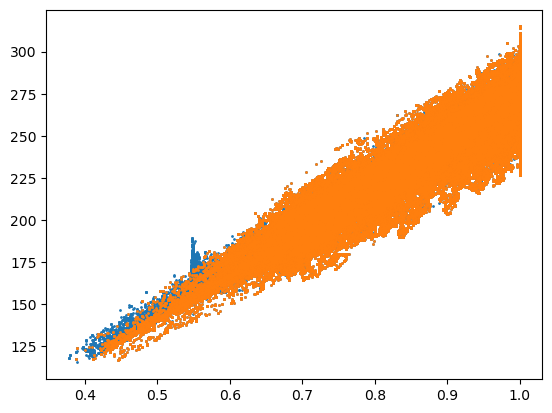

In [66]:
plt.scatter(es[valid_mask&lat_mask,0], tc_sim_scatt[valid_mask&lat_mask,0], s=1)
plt.scatter(es[valid_mask&(land_mask|snow_mask|ice_mask)&telsem_surf&lat_mask,0], tc_sim_scatt[valid_mask&(land_mask|snow_mask|ice_mask)&telsem_surf&lat_mask,0], s=1)
# plt.scatter(es[valid_mask&telsem_surf,0], tc_gmi[valid_mask&telsem_surf,0], s=1)
# plt.scatter(es[valid_mask&telsem_water,0], tc_gmi[valid_mask&telsem_water,0], s=1)

In [67]:
channels = q.gmi_channels()

# Direct models

In [68]:
features = np.array([
    *(tc_sim_scatt.T),
    # tcwv,
    surface_pressure,
    tm_dewpoint_temperature,
    tm_temperature,
    # skin_temperature,
    # autosnow,
]).T

labels = es[:,:]

feature_names = [
    *[f'Tc_{i}' for i in range(1, 14)],
    'surf pressure',
    't2m dewpoint temp',
    't2m temp',
    # 'skin temp',
    # 'autosnow',
]

In [69]:
# train_mask = np.array([True]*int(len(features)*split) + [False]*(len(features) - int(len(features)*split)))
train_mask = np.concatenate([np.full(size, np.random.choice([True, False], p=[0.7, 0.3])) for size in list(map(lambda x: len(x), map(np.load, autosnow_files)))], axis=0)
# train_mask = np.random.rand(features.shape[0]) < 0.7
test_mask = ~train_mask

use_data_mask = valid_mask&(land_mask|snow_mask|ice_mask)&telsem_surf&lat_mask
train_mask = train_mask & use_data_mask
test_mask = test_mask & use_data_mask

use_clear_sky_mask = clear_sky_mask[use_data_mask]

## Poly model

In [70]:
poly_features = PolynomialFeatures(degree=3)
X_train = poly_features.fit_transform(features[train_mask])
X_test = poly_features.transform(features[test_mask])
X = poly_features.transform(features[use_data_mask])

Y_train = labels[train_mask]
Y_test = labels[test_mask]
Y = labels[use_data_mask]

In [71]:
lin_reg = MultiOutputRegressor(LinearRegression())
lin_reg.fit(X_train, Y_train)

MultiOutputRegressor(estimator=LinearRegression())

In [72]:
P_train = np.clip(lin_reg.predict(X_train), 0, 1)
P_test = np.clip(lin_reg.predict(X_test), 0, 1)
P = np.clip(lin_reg.predict(X), 0, 1)

In [73]:
mae_train = metrics.mean_absolute_error(Y_train, P_train, multioutput='raw_values')
mae_test = metrics.mean_absolute_error(Y_test, P_test, multioutput='raw_values')
mape_train = metrics.mean_absolute_percentage_error(Y_train, P_train, multioutput='raw_values')
mape_test = metrics.mean_absolute_percentage_error(Y_test, P_test, multioutput='raw_values')

print(mae_train)
print(mae_test)
print(mape_train)
print(mape_test)

[0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.009 0.01  0.009 0.01  0.009
 0.009]
[0.006 0.006 0.006 0.006 0.006 0.006 0.006 0.011 0.013 0.011 0.013 0.011
 0.011]
[0.005 0.005 0.005 0.005 0.005 0.005 0.006 0.011 0.014 0.011 0.014 0.011
 0.011]
[0.007 0.009 0.007 0.009 0.007 0.008 0.009 0.014 0.018 0.014 0.018 0.014
 0.014]


Text(0.5, 0.98, 'MAE - Poly')

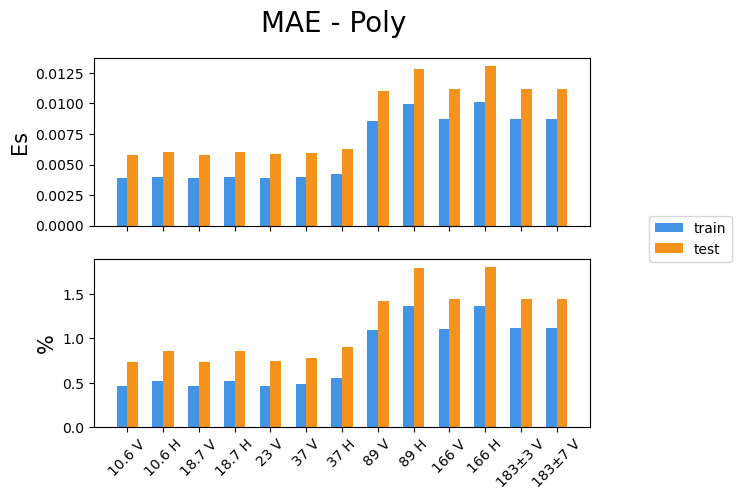

In [74]:
_x = np.array(list(range(labels.shape[1])))

plt.subplot(2, 1, 1)
plt.bar(_x-0.15, mae_train, width=0.3, color='#4394E5', label='train')
plt.bar(_x+0.15, mae_test, width=0.3, color='#F5921B', label='test')
plt.xticks(_x, [])
plt.ylabel('Es', fontsize=15)

plt.subplot(2, 1, 2)
plt.bar(_x-0.15, mape_train*100, width=0.3, color='#4394E5', label='train')
plt.bar(_x+0.15, mape_test*100, width=0.3, color='#F5921B', label='test')
plt.xticks(_x, channels[:len(_x)], rotation=45)
plt.ylabel('%', fontsize=15)

plt.legend(bbox_to_anchor=(1.3, 1.3))

plt.suptitle('MAE - Poly', fontsize=20)

In [75]:
_lin_p_test = P_test

## XGBOOST

In [76]:
X_train = features[train_mask]
X_test = features[test_mask]
X = features[use_data_mask]

Y_train = labels[train_mask]
Y_test = labels[test_mask]
Y = labels[use_data_mask]

In [77]:
xgb_reg = XGBRegressor(
    objective='reg:squarederror',
    max_depth=7,
    learning_rate=0.1,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=132,
)

xgb_reg.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=132, ...)

In [78]:
P_train = np.clip(xgb_reg.predict(X_train), 0, 1)
P_test = np.clip(xgb_reg.predict(X_test), 0, 1)
P = np.clip(xgb_reg.predict(X), 0, 1)

In [79]:
mae_train = metrics.mean_absolute_error(Y_train, P_train, multioutput='raw_values')
mae_test = metrics.mean_absolute_error(Y_test, P_test, multioutput='raw_values')
mape_train = metrics.mean_absolute_percentage_error(Y_train, P_train, multioutput='raw_values')
mape_test = metrics.mean_absolute_percentage_error(Y_test, P_test, multioutput='raw_values')

print(mae_train)
print(mae_test)
print(mape_train)
print(mape_test)

[0.002 0.003 0.002 0.003 0.003 0.004 0.004 0.006 0.008 0.006 0.008 0.007
 0.006]
[0.006 0.006 0.006 0.006 0.006 0.009 0.009 0.013 0.016 0.014 0.016 0.014
 0.014]
[0.003 0.004 0.003 0.004 0.003 0.004 0.005 0.008 0.011 0.008 0.011 0.009
 0.008]
[0.007 0.008 0.007 0.008 0.008 0.011 0.012 0.018 0.022 0.018 0.022 0.019
 0.019]


Text(0.5, 0.98, 'MAE - GBRT')

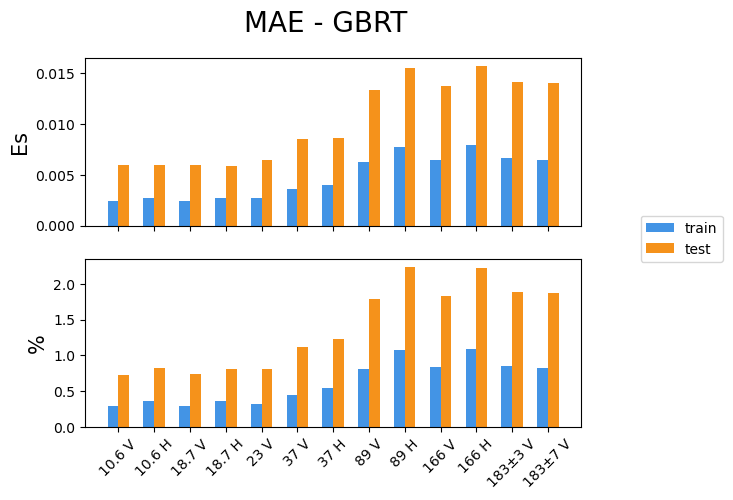

In [80]:
_x = np.array(list(range(labels.shape[1])))

plt.subplot(2, 1, 1)
plt.bar(_x-0.15, mae_train, width=0.3, color='#4394E5', label='train')
plt.bar(_x+0.15, mae_test, width=0.3, color='#F5921B', label='test')
plt.xticks(_x, [])
plt.ylabel('Es', fontsize=15)

plt.subplot(2, 1, 2)
plt.bar(_x-0.15, mape_train*100, width=0.3, color='#4394E5', label='train')
plt.bar(_x+0.15, mape_test*100, width=0.3, color='#F5921B', label='test')
plt.xticks(_x, channels[:len(_x)], rotation=45)
plt.ylabel('%', fontsize=15)

plt.legend(bbox_to_anchor=(1.3, 1.3))

plt.suptitle('MAE - GBRT', fontsize=20)

In [81]:
_xgb_p_test = P_test

## GBRT model

In [82]:
X_train = features[train_mask]
X_test = features[test_mask]
X = features[use_data_mask]

Y_train = labels[train_mask]
Y_test = labels[test_mask]
Y = labels[use_data_mask]

In [83]:
gbrt_reg = MultiOutputRegressor(HistGradientBoostingRegressor(verbose=1))
gbrt_reg.fit(X_train, Y_train)

Binning 0.020 GB of training data: 

0.227 s
Binning 0.002 GB of validation data: 0.001 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 6, train loss: 0.00634, val loss: 0.00633, in 0.007s
[2/100] 1 tree, 31 leaves, max depth = 6, train loss: 0.00518, val loss: 0.00517, in 0.006s
[3/100] 1 tree, 31 leaves, max depth = 6, train loss: 0.00424, val loss: 0.00423, in 0.006s
[4/100] 1 tree, 31 leaves, max depth = 6, train loss: 0.00346, val loss: 0.00346, in 0.005s
[5/100] 1 tree, 31 leaves, max depth = 6, train loss: 0.00284, val loss: 0.00283, in 0.005s
[6/100] 1 tree, 31 leaves, max depth = 6, train loss: 0.00232, val loss: 0.00232, in 0.006s
[7/100] 1 tree, 31 leaves, max depth = 6, train loss: 0.00191, val loss: 0.00190, in 0.006s
[8/100] 1 tree, 31 leaves, max depth = 7, train loss: 0.00157, val loss: 0.00157, in 0.005s
[9/100] 1 tree, 31 leaves, max depth = 6, train loss: 0.00129, val loss: 0.00129, in 0.005s
[10/100] 1 tree, 31 leaves, max depth = 6, train loss: 0.00106, val loss: 0.00106, in 

MultiOutputRegressor(estimator=HistGradientBoostingRegressor(verbose=1))

In [84]:
# sorted(list(zip(gbrt_reg.estimators_[0].feature_importances_, feature_names)), reverse=True)

In [85]:
P_train = np.clip(gbrt_reg.predict(X_train), 0, 1)
P_test = np.clip(gbrt_reg.predict(X_test), 0, 1)
P = np.clip(gbrt_reg.predict(X), 0, 1)

In [86]:
mae_train = metrics.mean_absolute_error(Y_train, P_train, multioutput='raw_values')
mae_test = metrics.mean_absolute_error(Y_test, P_test, multioutput='raw_values')
mape_train = metrics.mean_absolute_percentage_error(Y_train, P_train, multioutput='raw_values')
mape_test = metrics.mean_absolute_percentage_error(Y_test, P_test, multioutput='raw_values')

print(mae_train)
print(mae_test)
print(mape_train)
print(mape_test)

[0.004 0.004 0.004 0.004 0.005 0.006 0.007 0.011 0.013 0.011 0.013 0.011
 0.011]
[0.006 0.006 0.006 0.006 0.007 0.009 0.01  0.014 0.017 0.014 0.017 0.015
 0.015]
[0.005 0.006 0.005 0.006 0.005 0.008 0.01  0.014 0.018 0.014 0.018 0.014
 0.014]
[0.008 0.009 0.008 0.009 0.008 0.012 0.014 0.019 0.024 0.019 0.024 0.02
 0.019]


Text(0.5, 0.98, 'MAE - GBRT')

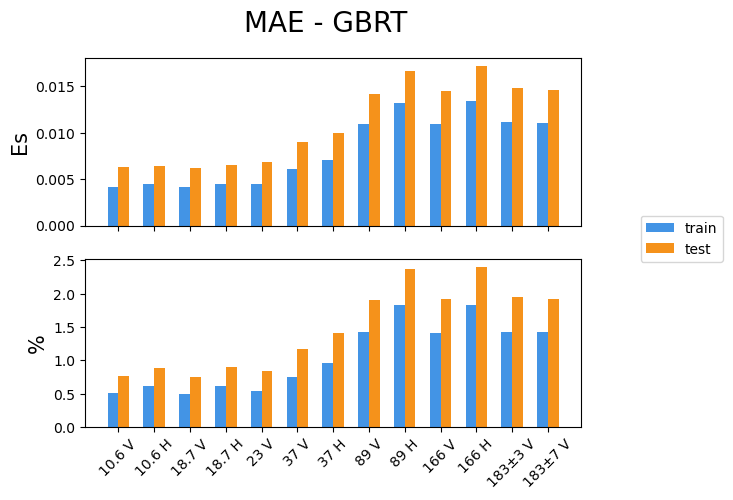

In [87]:
_x = np.array(list(range(labels.shape[1])))

plt.subplot(2, 1, 1)
plt.bar(_x-0.15, mae_train, width=0.3, color='#4394E5', label='train')
plt.bar(_x+0.15, mae_test, width=0.3, color='#F5921B', label='test')
plt.xticks(_x, [])
plt.ylabel('Es', fontsize=15)

plt.subplot(2, 1, 2)
plt.bar(_x-0.15, mape_train*100, width=0.3, color='#4394E5', label='train')
plt.bar(_x+0.15, mape_test*100, width=0.3, color='#F5921B', label='test')
plt.xticks(_x, channels[:len(_x)], rotation=45)
plt.ylabel('%', fontsize=15)

plt.legend(bbox_to_anchor=(1.3, 1.3))

plt.suptitle('MAE - GBRT', fontsize=20)

In [88]:
_gbrt_p_test = P_test

## NN model

In [89]:
val_mask = np.concatenate([np.full(size, np.random.choice([True, False], p=[0.3, 0.7])) for size in list(map(lambda x: len(x), map(np.load, autosnow_files)))], axis=0)

X_train = features[train_mask&(~val_mask)]
X_test = features[test_mask]
X_val = features[train_mask&(val_mask)]
X = features[use_data_mask]

Y_train = labels[train_mask&(~val_mask)]
Y_test = labels[test_mask]
Y_val = labels[train_mask&(val_mask)]
Y = labels[use_data_mask]

In [90]:
min_max = np.array([
    [50, 400],
    [50, 400],
    [50, 400],
    [50, 400],
    [50, 400],
    [50, 400],
    [50, 400],
    [50, 400],
    [50, 400],
    [50, 400],
    [50, 400],
    [50, 400],
    [50, 400],
    [40000, 150000],
    [200, 350],
    [200, 350],
    # [0, 7],
    # [0, 0.25],
])

X_train_norm = (X_train - min_max[:,0]) / (min_max[:,1] - min_max[:,0]) - 0.5
X_test_norm = (X_test - min_max[:,0]) / (min_max[:,1] - min_max[:,0]) - 0.5
X_val_norm = (X_val - min_max[:,0]) / (min_max[:,1] - min_max[:,0]) - 0.5
X_norm = (X - min_max[:,0]) / (min_max[:,1] - min_max[:,0]) - 0.5
# X_train_norm = (X_train - X_train.mean(axis=0)) / (X_train.std(axis=0))
# X_test_norm = (X_test - X_train.mean(axis=0)) / (X_train.std(axis=0))
# X_val_norm = (X_val - X_train.mean(axis=0)) / (X_train.std(axis=0))
# X_norm = (X - X_train.mean(axis=0)) / (X_train.std(axis=0))

Y_train_norm = np.clip(2*(Y_train - 0.5), 0, 1)
Y_test_norm = np.clip(2*(Y_test - 0.5), 0, 1)
Y_val_norm = np.clip(2*(Y_val - 0.5), 0, 1)
Y_norm = np.clip(2*(Y - 0.5), 0, 1)

train_loader = DataLoader(TensorDataset(torch.Tensor(X_train_norm), torch.Tensor(Y_train_norm)), batch_size=256, shuffle=True)
test_loader = DataLoader(TensorDataset(torch.Tensor(X_test_norm), torch.Tensor(Y_test_norm)), batch_size=256)
val_loader = DataLoader(TensorDataset(torch.Tensor(X_val_norm), torch.Tensor(Y_val_norm)), batch_size=256)

In [91]:
import direct
from importlib import reload
reload(direct)

model = direct.SimpleNN()

early_stopper = direct.EarlyStopping(patience=10)
trainer = direct.ModelTrainer(model, early_stopper=early_stopper, lr=0.001)

trainer.train(train_loader, val_loader, epochs=1000)
trainer.test(test_loader)

Epoch 1/1000, Train Loss: 0.0156, Val Loss: 0.0036
Epoch 2/1000, Train Loss: 0.0016, Val Loss: 0.0021
Epoch 3/1000, Train Loss: 0.0012, Val Loss: 0.0017
Epoch 4/1000, Train Loss: 0.0011, Val Loss: 0.0016
Epoch 5/1000, Train Loss: 0.0010, Val Loss: 0.0016
Epoch 6/1000, Train Loss: 0.0009, Val Loss: 0.0015
Epoch 7/1000, Train Loss: 0.0009, Val Loss: 0.0015
Epoch 8/1000, Train Loss: 0.0008, Val Loss: 0.0015
Epoch 9/1000, Train Loss: 0.0008, Val Loss: 0.0014
Epoch 10/1000, Train Loss: 0.0007, Val Loss: 0.0014
Epoch 11/1000, Train Loss: 0.0007, Val Loss: 0.0014
Epoch 12/1000, Train Loss: 0.0007, Val Loss: 0.0014
Epoch 13/1000, Train Loss: 0.0006, Val Loss: 0.0014
Epoch 14/1000, Train Loss: 0.0006, Val Loss: 0.0014
Epoch 15/1000, Train Loss: 0.0006, Val Loss: 0.0014
Epoch 16/1000, Train Loss: 0.0006, Val Loss: 0.0014
Epoch 17/1000, Train Loss: 0.0006, Val Loss: 0.0013
Epoch 18/1000, Train Loss: 0.0006, Val Loss: 0.0013
Epoch 19/1000, Train Loss: 0.0006, Val Loss: 0.0014
Epoch 20/1000, Train 

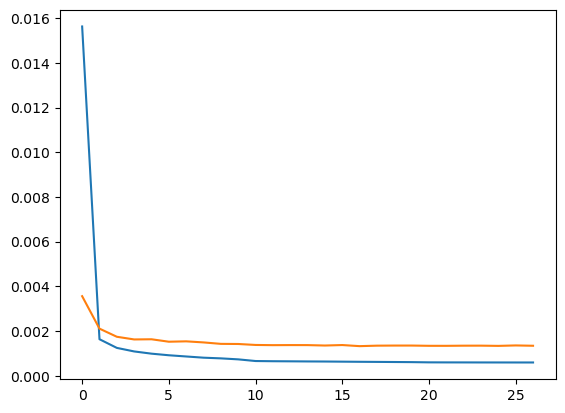

In [92]:
plt.plot(trainer.train_hist[:])
plt.plot(trainer.val_hist[:])

In [93]:
with torch.no_grad():
    P_train = np.clip(model(torch.Tensor(X_train_norm)).numpy()/2+0.5, 0, 1)
    P_test = np.clip(model(torch.Tensor(X_test_norm)).numpy()/2+0.5, 0, 1)
    P = np.clip(model(torch.Tensor(X_norm)).numpy()/2+0.5, 0, 1)

In [94]:
mae_train = metrics.mean_absolute_error(Y_train, P_train, multioutput='raw_values')
mae_test = metrics.mean_absolute_error(Y_test, P_test, multioutput='raw_values')
mape_train = metrics.mean_absolute_percentage_error(Y_train, P_train, multioutput='raw_values')
mape_test = metrics.mean_absolute_percentage_error(Y_test, P_test, multioutput='raw_values')

print(mae_train)
print(mae_test)
print(mape_train)
print(mape_test)

[0.004 0.009 0.004 0.009 0.004 0.006 0.01  0.009 0.013 0.009 0.012 0.009
 0.009]
[0.006 0.011 0.006 0.011 0.006 0.008 0.012 0.012 0.016 0.012 0.015 0.012
 0.012]
[0.005 0.021 0.005 0.021 0.005 0.007 0.018 0.012 0.02  0.012 0.018 0.012
 0.012]
[0.007 0.024 0.007 0.024 0.007 0.011 0.021 0.016 0.026 0.016 0.022 0.016
 0.016]


Text(0.5, 0.98, 'MAE - NN')

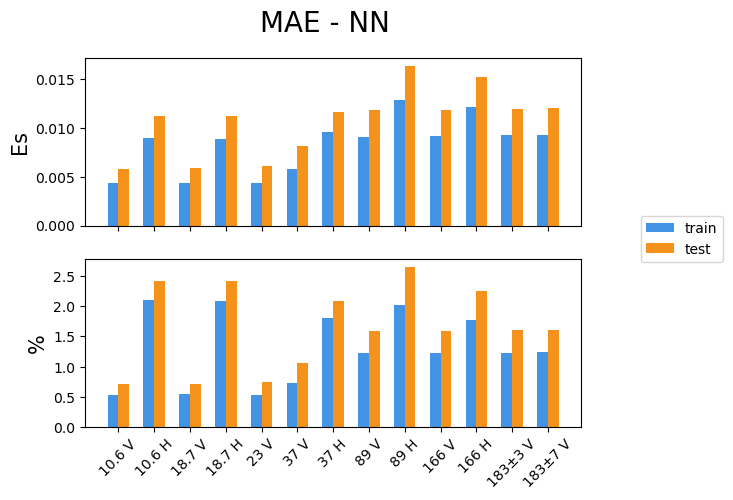

In [95]:
_x = np.array(list(range(labels.shape[1])))

plt.subplot(2, 1, 1)
plt.bar(_x-0.15, mae_train, width=0.3, color='#4394E5', label='train')
plt.bar(_x+0.15, mae_test, width=0.3, color='#F5921B', label='test')
plt.xticks(_x, [])
plt.ylabel('Es', fontsize=15)

plt.subplot(2, 1, 2)
plt.bar(_x-0.15, mape_train*100, width=0.3, color='#4394E5', label='train')
plt.bar(_x+0.15, mape_test*100, width=0.3, color='#F5921B', label='test')
plt.xticks(_x, channels[:len(_x)], rotation=45)
plt.ylabel('%', fontsize=15)

plt.legend(bbox_to_anchor=(1.3, 1.3))

plt.suptitle('MAE - NN', fontsize=20)

In [96]:
_nn_p_test = P_test

## Unsupervised

In [97]:
val_mask = np.concatenate([np.full(size, np.random.choice([True, False], p=[0.3, 0.7])) for size in list(map(lambda x: len(x), map(np.load, autosnow_files)))], axis=0)

X_train = features[train_mask&(~val_mask)]
X_test = features[test_mask]
X_val = features[train_mask&(val_mask)]
X = features[use_data_mask]

Y_train = labels[train_mask&(~val_mask)]
Y_test = labels[test_mask]
Y_val = labels[train_mask&(val_mask)]
Y = labels[use_data_mask]

In [98]:
kmeans = KMeans(n_clusters=3, random_state=132)
p_train = kmeans.fit_predict(X_train)

kmean_es = KMeans(n_clusters=3, random_state=132)
p_train_es = kmean_es.fit_predict(Y_train)

In [99]:
p = kmeans.predict(X)
p_es = kmean_es.predict(Y)

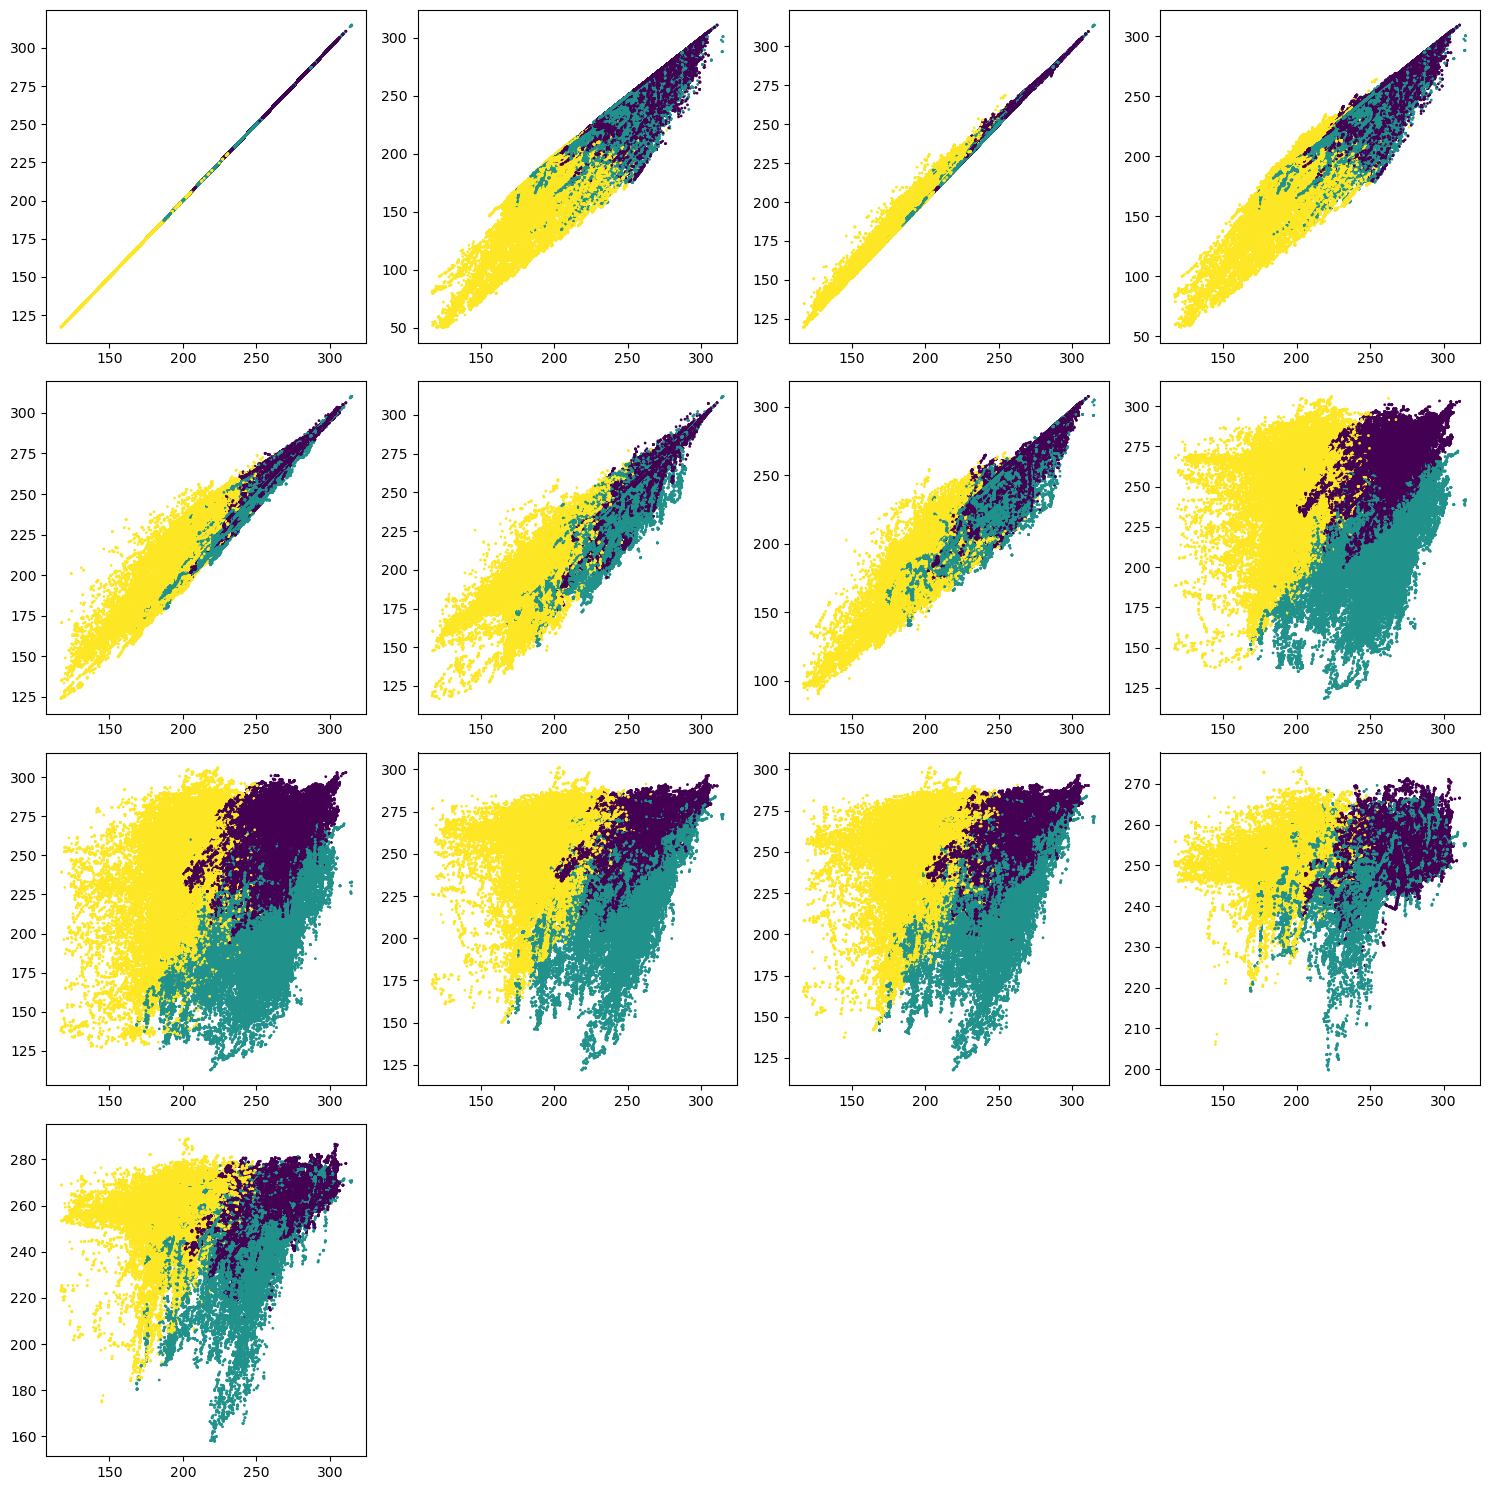

In [100]:
plt.figure(figsize=(15, 15))
for chan in range(13):
    plt.subplot(4, 4, chan+1)
    plt.scatter(X[:,0], X[:,chan], s=1, c=p_es)
plt.tight_layout()

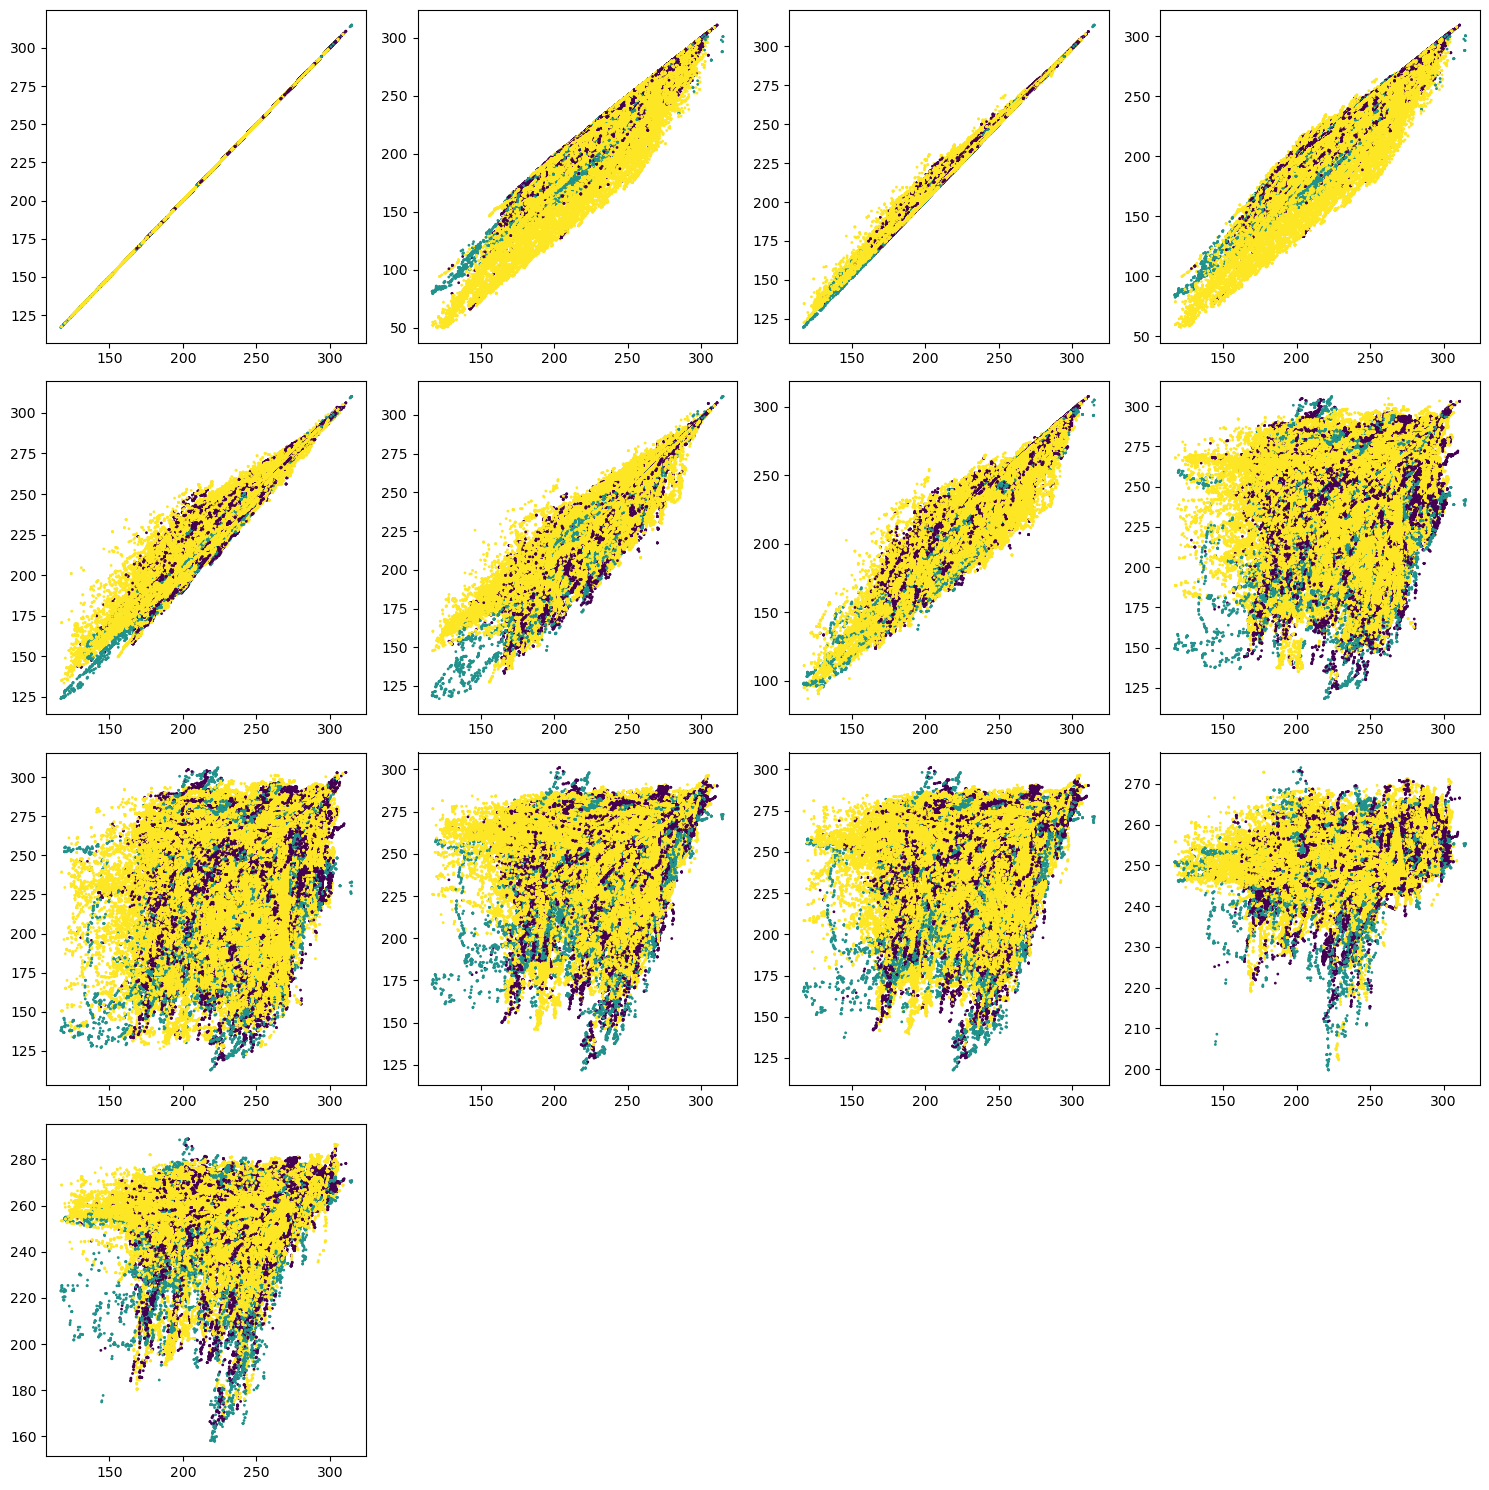

In [101]:
plt.figure(figsize=(15, 15))
for chan in range(13):
    plt.subplot(4, 4, chan+1)
    plt.scatter(X[:,0], X[:,chan], s=1, c=p)
plt.tight_layout()

## Post analysis

/home/mykhailo/micromamba/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mykhailo/micromamba/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


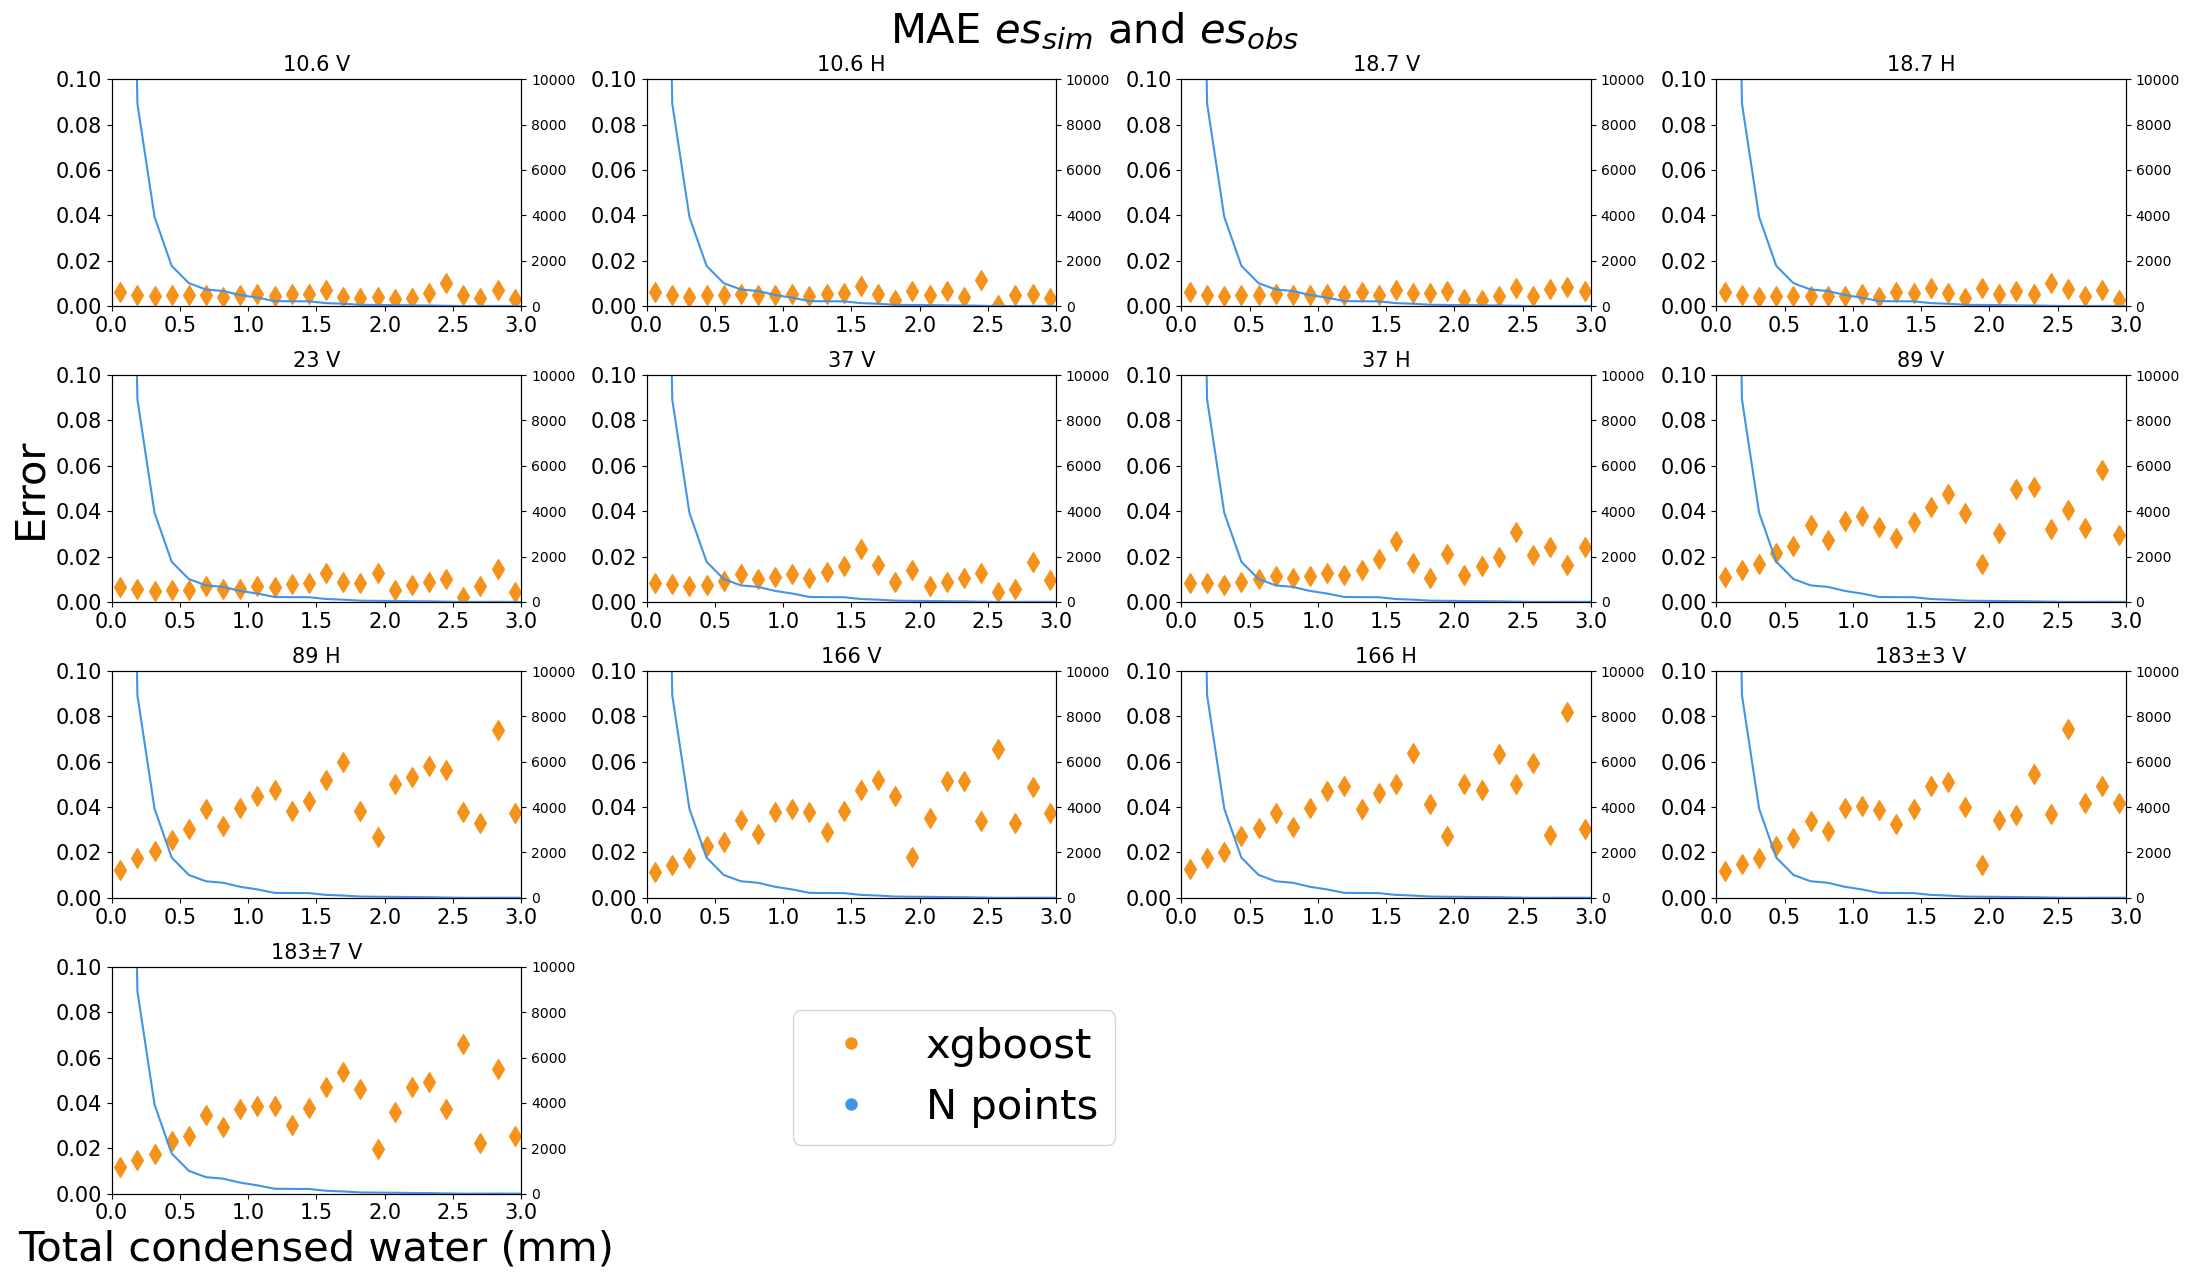

In [102]:
use_mask = land_mask | snow_mask | ice_mask

nbins = 100

bins = np.linspace(tcwv[use_mask].min(), tcwv[use_mask].max(), nbins+1)

error_xgboost = _xgb_p_test - Y_test

bin_indices = np.digitize(tcwv[use_data_mask&test_mask], bins) - 1

plt.figure(figsize=(22, 13))
for chan in range(13):
    plt.subplot(4, 4, chan+1)
    avg_errors_xgboost = []
    nsamples = []

    for i in range(nbins):
        bin_mask = bin_indices == i
        
        avg_errors_xgboost.append(np.mean(np.abs(error_xgboost[bin_mask,chan])))
        nsamples.append(len(error_xgboost[bin_mask,chan]))

    avg_errors_xgboost = np.array(avg_errors_xgboost)

    bin_centers = (bins[:-1] + bins[1:]) / 2

    plt.scatter(bin_centers, avg_errors_xgboost, c='#F5921B', marker='d', label='xgboost', s=100)

    if chan == 12:
        plt.xlabel('Total condensed water (mm)', fontsize=30)
    if chan == 4:
        plt.ylabel('Error', fontsize=30)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    plt.title(channels[chan], fontsize=15)
    plt.xlim(0, 3)
    plt.ylim(0, 0.1)

    ax2 = plt.gca().twinx()
    ax2.plot(bin_centers, nsamples, c='#4394E5')
    ax2.set_ylim(0, 10000)

plt.suptitle('MAE $es_{sim}$ and $es_{obs}$', fontsize=30)
plt.tight_layout()

legend_handles = [
    matplotlib.lines.Line2D([0], [0], marker='o', color='w', markerfacecolor='#F5921B', markersize=10, label='xgboost'),
    matplotlib.lines.Line2D([0], [0], marker='o', color='w', markerfacecolor='#4394E5', markersize=10, label='N points'),
]
plt.legend(handles=legend_handles, bbox_to_anchor=(2.5, 0.9), fontsize=30)

In [103]:
lin_err = (metrics.mean_absolute_error(Y_test, _lin_p_test, multioutput='raw_values'))
grbt_err = (metrics.mean_absolute_error(Y_test, _gbrt_p_test, multioutput='raw_values'))
nn_err = (metrics.mean_absolute_error(Y_test, _nn_p_test, multioutput='raw_values'))
xgb_err = (metrics.mean_absolute_error(Y_test, _xgb_p_test, multioutput='raw_values'))

for i in range(len(channels)):
    print(f'{channels[i]:8s} {lin_err[i]:.3f} {grbt_err[i]:.3f} {nn_err[i]:.3f} {xgb_err[i]:.3f}')

10.6 V   0.006 0.006 0.006 0.006
10.6 H   0.006 0.006 0.011 0.006
18.7 V   0.006 0.006 0.006 0.006
18.7 H   0.006 0.006 0.011 0.006
23 V     0.006 0.007 0.006 0.006
37 V     0.006 0.009 0.008 0.009
37 H     0.006 0.010 0.012 0.009
89 V     0.011 0.014 0.012 0.013
89 H     0.013 0.017 0.016 0.016
166 V    0.011 0.014 0.012 0.014
166 H    0.013 0.017 0.015 0.016
183±3 V  0.011 0.015 0.012 0.014
183±7 V  0.011 0.015 0.012 0.014


(0.5, 1.0)

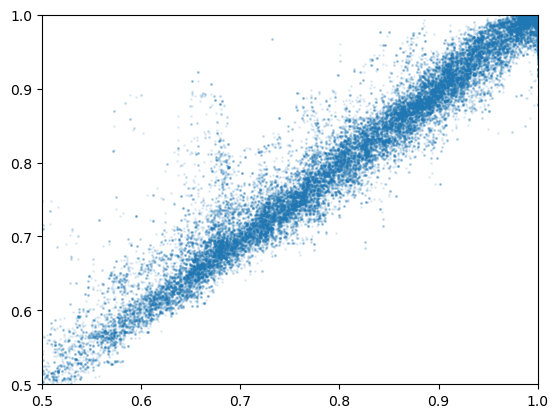

In [104]:
c = 11

_land_mask = land_mask[test_mask]
_snow_mask = snow_mask[test_mask]
_ice_mask = ice_mask[test_mask]

# plt.scatter(Y_test[_land_mask,c], _lin_p_test[_land_mask,c], s=1)
# plt.scatter(Y_test[_snow_mask,c], _lin_p_test[_snow_mask,c], s=1)
# plt.scatter(Y_test[:,c], _lin_p_test[:,c], s=1, alpha=0.1)
# plt.scatter(Y_test[_ice_mask,c], _lin_p_test[_ice_mask,c], s=1)
plt.scatter(Y_test[:,c], _gbrt_p_test[:,c], s=1, alpha=0.1)
# plt.scatter(Y_test[:,c], _nn_p_test[:,c], s=1)


plt.xlim(0.5, 1)
plt.ylim(0.5, 1)

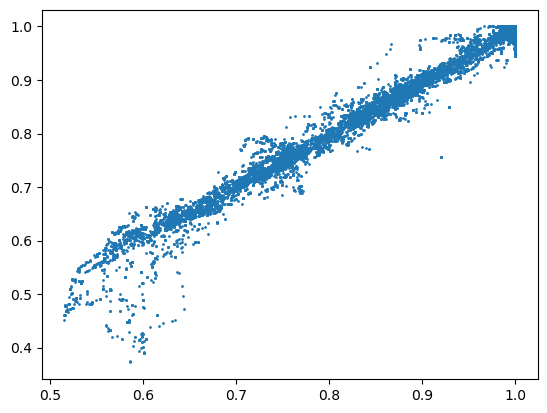

In [105]:
c = 9
plt.scatter(_nn_p_test[_ice_mask,c], _lin_p_test[_ice_mask,c], s=1)